# Non-Parametric Density Estimation 
## Kernel Density Estimation (Parzen-Rosenblatt Window Estimation)
## 1. Univariate Case
## 2. Multivariate Case

#### A comparison of my implementation of univariate and bivariate KDE, vs seaborn's built-in kdeplot function

<hr>
<hr>

## 1. Univariate (1D) Case:

### 1a) Generate synthetic 1D data (Gaussian normal)

In [1]:
import numpy as np

# specify parameters of 2 different populations
mean1 = 5
var1 = 1
mean2 = 0
var2 = 0.2
N1 = 1000
N2 = 1000

# generate random samples for each population
dist1 = np.random.normal(mean1, var1, N1).reshape(-1,1)
dist2 = np.random.normal(mean2, var2, N2).reshape(-1,1)

# data is combination of random samples from 2 different populations
data = np.concatenate([dist1, dist2],axis=0)

print("1D Data: \n", data[0:7])

1D Data: 
 [[4.72885245]
 [5.49392836]
 [4.35932123]
 [6.29149697]
 [6.40121185]
 [6.14187146]
 [5.42292095]]


### 1b) Define 4 different kernel functions

In [2]:
def kernel_hypercube(u):
    if abs(u) <= 0.5:
        return 1
    else:
        return 0

In [3]:
import math

def kernel_gaussian(u):
    if abs(u) <= 1:
        return 1/((2*math.pi)**0.5) * math.exp(-1/2 * u**2)
    else:
        return 0

In [4]:
def kernel_epanechnikov(u):
    if abs(u) <= 1:
        return (3/4 * (1-u**2))
    else:
        return 0

In [5]:
def kernel_triangle(u):
    if abs(u) <= 1:
        return (1-abs(u))
    else:
        return 0

### 1c) Implement Univariate KDE algorithm

In [6]:
def my_kde_univariate(data, h, kernel_type='hypercube'):
    # get x axis values for continuous PDF across data set range
    X = np.arange(np.amin(data), np.amax(data), 0.01)
    N = np.size(X,0)
    d = 1 # dimensions 
    probs = [] # kernel densities for each sample
    
    if kernel_type=='hypercube':
            K = kernel_hypercube
    elif kernel_type=='gaussian':
            K = kernel_gaussian
    elif kernel_type=='epanechnikov':
            K = kernel_epanechnikov
    elif kernel_type=='triangle':
            K = kernel_triangle
    
    # get density estimates for each row in X
    for x in X:
        px = 1/N * 1/(h**d) * sum([ K((x-di)/h) for di in data ])
        probs.append(px) # append new row px to array probs
        
    return X, probs

### 1d) Estimate PDF using 3 different kernels, fixed h

In [7]:
h = 0.5

X_hc, probs_hc = my_kde_univariate(data, h, kernel_type='hypercube')

X_g, probs_g = my_kde_univariate(data, h, kernel_type='gaussian')

X_ep, probs_ep = my_kde_univariate(data, h, kernel_type='epanechnikov')

X_t, probs_t = my_kde_univariate(data, h, kernel_type='triangle')

### 1e) Visualize the PDFs of different kernel functions (for fixed h)
#### Choice of kernel function is not crucial - they produce near identical PDFs

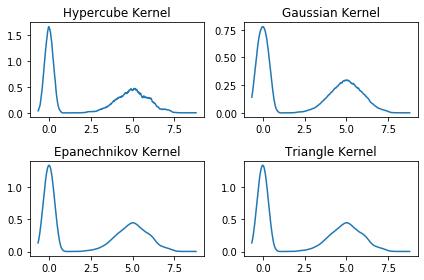

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2)

ax[0,0].plot(X_hc, probs_hc)
ax[0,0].set_title('Hypercube Kernel')
ax[0,1].plot(X_g, probs_g)
ax[0,1].set_title('Gaussian Kernel')
ax[1,0].plot(X_ep, probs_ep)
ax[1,0].set_title('Epanechnikov Kernel')
ax[1,1].plot(X_ep, probs_ep)
ax[1,1].set_title('Triangle Kernel')

fig.tight_layout() # for good padding between stacked subplots

### 1f) Estimate PDF using different bandwidths, fixed kernel

In [11]:
# default kernel is 'hypercube'

X_1, probs_1 = my_kde_univariate(data, h=0.1, 'hypercube')

X_2, probs_2 = my_kde_univariate(data, h=0.5, 'hypercube')

X_3, probs_3 = my_kde_univariate(data, h=1, 'hypercube')

X_4, probs_4 = my_kde_univariate(data, h=5, 'hypercube')

### 1f) Visualize different PDFs from different bandwidth h (fixed kernel)

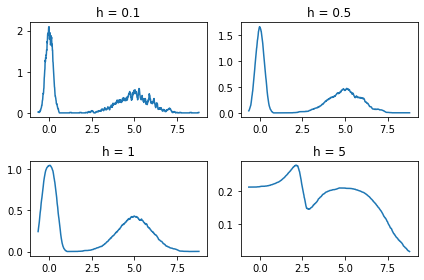

In [12]:
fig, ax = plt.subplots(2,2)

ax[0,0].plot(X_1, probs_1)
ax[0,0].set_title('h = 0.1')
ax[0,1].plot(X_2, probs_2)
ax[0,1].set_title('h = 0.5')
ax[1,0].plot(X_3, probs_3)
ax[1,0].set_title('h = 1')
ax[1,1].plot(X_4, probs_4)
ax[1,1].set_title('h = 5')

fig.tight_layout()

### 1g) Compare results with seaborn built-in kdeplot

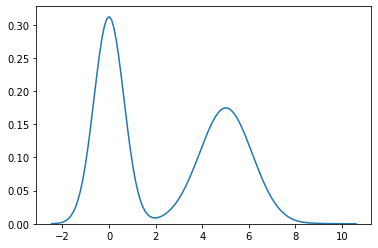

In [165]:
import seaborn 

ax = seaborn.kdeplot(data.ravel())

<hr>

## 2. Multivariate (2D) Case
### Kernel Density Estimation with Product Kernels

### 2a) Generate synthetic 2D data

In [79]:
# specify parameters of 2 different populations
mean1 = [1,0]
var1 = [[0.9,0.4],[0.4,0.9]]
mean2 = [-2,-2]
var2 = [[0.9,0.4],[0.4,0.9]]
N1 = 500
N2 = 500

# generate random samples for each population
dist1_2d = np.random.multivariate_normal(mean1, var1, N1)
dist2_2d = np.random.multivariate_normal(mean2, var2, N2)

# data is vertical concat of random samples from 2 different populations
data_2d = np.concatenate([dist1_2d, dist2_2d], axis=0)

print("2D Data: \n", data_2d[0:7,:])

2D Data: 
 [[-0.12280283  0.98903964]
 [ 0.65470654 -0.65846165]
 [ 2.35170176  0.30730686]
 [ 0.31952009  0.49773555]
 [-0.83107758 -1.59789298]
 [-0.57386015 -1.01116639]
 [ 1.06396919 -1.48118772]]


### 2b) Implement Bivariate Product Kernel KDE

In [135]:
def product_kernel(K,dp,x,h):
    dim = len(dp)
    prod = 1
    for j in range(0,dim):
        prod *= K((x[j]-dp[j])/h)
    return prod

def my_kde_bivariate(data_2d, h, kernel_type='hypercube'):
    # get all feature axis values for continuous PDF across data set range
    x = np.linspace(np.amin(data_2d[:,0]), np.amax(data_2d[:,0]), 100).reshape(-1,1)
    y = np.linspace(np.amin(data_2d[:,1]), np.amax(data_2d[:,1]), 100).reshape(-1,1)
    
    # these 2 lines necessary for later reshaping of probs for 3d plot
    xx, yy = np.meshgrid(x,y)
    X_2d = np.concatenate([xx.ravel().reshape(-1,1), yy.ravel().reshape(-1,1)], axis=1)
    
    N = np.size(X_2d,0)
    d = np.size(data_2d,1) # dimensions of original data set
    probs = [] # store kernel densities for each location
    
    if kernel_type=='hypercube':
            K = kernel_hypercube
    elif kernel_type=='gaussian':
            K = kernel_gaussian
    elif kernel_type=='epanechnikov':
            K = kernel_epanechnikov
    elif kernel_type=='triangle':
            K = kernel_triangle
    
    # get density estimates for each row in X
    for x in X_2d:
        px = 1/N * 1/(h**d) * np.sum([product_kernel(K,dp,x,h) for dp in data_2d]) # use product kernel for each dim, same h
        probs.append(px) # append new row px to array probs
    
    return xx, yy, probs

### 2c) Estimate PDF using different kernels, h fixed

In [111]:
h = 0.5

xx1, yy1, z1 = my_kde_bivariate(data_2d, h, 'hypercube')

xx2, yy2, z2 = my_kde_bivariate(data_2d, h, 'gaussian')

xx3, yy3, z3 = my_kde_bivariate(data_2d, h, 'epanechnikov')

xx4, yy4, z4 = my_kde_bivariate(data_2d, h, 'triangle')

### 2d) Visualize different PDFs for different kernels, fixed h
##### (i) Using 3D contour plots

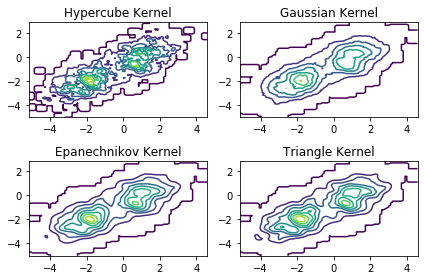

In [114]:
# reshape (N,) prob-density array into (N^0.5,N^0.5) for contour plot grid
zz1 = np.array(z1).reshape(xx1.shape)
zz2 = np.array(z2).reshape(xx2.shape)
zz3 = np.array(z3).reshape(xx3.shape)
zz4 = np.array(z4).reshape(xx4.shape)

# plot contour plots of KDE
fig, ax = plt.subplots(2,2)

ax[0,0].contour(xx1,yy1,zz1)
ax[0,0].set_title('Hypercube Kernel')
ax[0,1].contour(xx2,yy2,zz2)
ax[0,1].set_title('Gaussian Kernel')
ax[1,0].contour(xx3,yy3,zz3)
ax[1,0].set_title('Epanechnikov Kernel')
ax[1,1].contour(xx4,yy4,zz4)
ax[1,1].set_title('Triangle Kernel')

fig.tight_layout()

##### (i) Use 3D surface plots

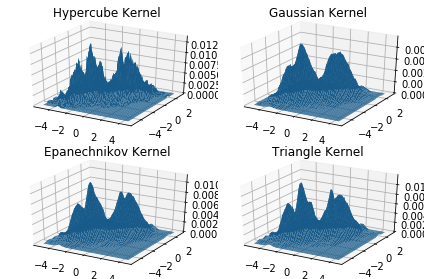

In [127]:
from mpl_toolkits.mplot3d import Axes3D

# plot surface plots of KDE
fig = plt.figure()

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(xx1,yy1,zz1)
ax.set_title('Hypercube Kernel')
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot_surface(xx2,yy2,zz2)
ax.set_title('Gaussian Kernel')
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot_surface(xx3,yy3,zz3)
ax.set_title('Epanechnikov Kernel')
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(xx4,yy4,zz4)
ax.set_title('Triangle Kernel')

fig.tight_layout()

### 2c) Estimate PDF using different bandwidths, kernel fixed

In [136]:
xx1, yy1, z1 = my_kde_bivariate(data_2d, h=0.1, kernel_type='gaussian')

xx2, yy2, z2 = my_kde_bivariate(data_2d, h=0.5, kernel_type='gaussian')

xx3, yy3, z3 = my_kde_bivariate(data_2d, h=1, kernel_type='gaussian')

xx4, yy4, z4 = my_kde_bivariate(data_2d, h=5, kernel_type='gaussian')

### 2d) Visualize different PDFs for different bandwidths, kernel fixed
##### (i) Using 3D contour plot

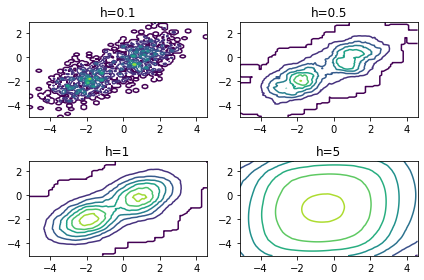

In [152]:
# reshape (N,) prob-density array into (N^0.5,N^0.5) for contour plot grid
zz1 = np.array(z1).reshape(xx1.shape)
zz2 = np.array(z2).reshape(xx2.shape)
zz3 = np.array(z3).reshape(xx3.shape)
zz4 = np.array(z4).reshape(xx4.shape)

# plot contour plots of KDE
fig, ax = plt.subplots(2,2)

ax[0,0].contour(xx1,yy1,zz1)
ax[0,0].set_title('h=0.1')
ax[0,1].contour(xx2,yy2,zz2)
ax[0,1].set_title('h=0.5')
ax[1,0].contour(xx3,yy3,zz3)
ax[1,0].set_title('h=1')
ax[1,1].contour(xx4,yy4,zz4)
ax[1,1].set_title('h=5')

fig.tight_layout()

##### (ii) Using 3D surface plot

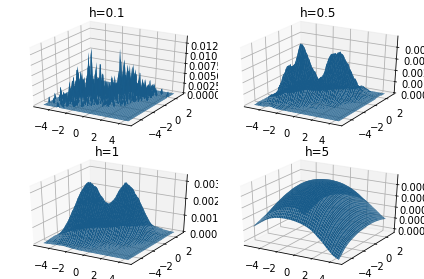

In [147]:
from mpl_toolkits.mplot3d import Axes3D

# plot surface plots of KDE
fig = plt.figure()

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(xx1,yy1,zz1)
ax.set_title('h=0.1')
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot_surface(xx2,yy2,zz2)
ax.set_title('h=0.5')
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot_surface(xx3,yy3,zz3)
ax.set_title('h=1')
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(xx4,yy4,zz4)
ax.set_title('h=5')

fig.tight_layout()

### 2e) Compare results with seaborn kernel density function

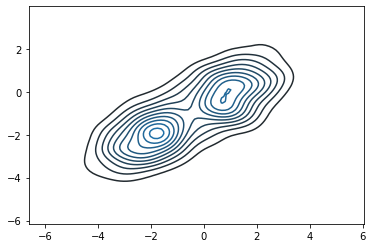

In [160]:
import seaborn 
ax = seaborn.kdeplot(data_2d[:,0], data_2d[:,1])